# Práctica 5: SIFT + machine learning

#### Procesamiento de imágenes digitales <br> Máster en Ciencia del dato y aprendizaje automático.

En esta práctica vamos a usar machine learning (no deep learning) para clasificar imágenes. 
Para ello, tendremos que hacer la extracción de características (feature extraction) y la
selección de características (feature selection) nosotros.

Vamos a utilizar el algoritmo SIFT explicado en clase para detectar los puntos clave que nos
ayudarán a extraer y seleccionar características.

<b> Muy importante: </b> SIFT es un algoritmo patentado, cuya patente expiró en 2020. Si tenemos
instaladas versiones viejas de opencv seguramente al intentar utilizarlo salga un error similar
a 
<code>"This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'cv::xfeatures2d::SIFT::create'"</code>.

En mi caso, la versión de OpenCV 4.7.0 funciona perfecta. La instalé con <code>pip install opencv-python</code>. Si partimos desde un entorno creado desde cero, necesitaremos instalar:

- Opencv: <code>pip install opencv-python</code>
- Matplotlib: <code>pip install matplotlib</code>
- Scikit-learn: <code>pip install scikit-learn</code>

Antes de nada, importamos y comprobamos la versión de OpenCV que tenemos:

In [1]:
import cv2
cv2.__version__

'4.7.0'

Importamos unas cuantas librerías que nos harán falta:

In [ ]:
import matplotlib.pyplot as plt # Para dibujar
import numpy as np # Para los arrays 
from sklearn.cluster import MiniBatchKMeans,KMeans # Para hacer clustering
from sklearn import svm # Para hacer clasificación
import os # Para leer ficheros del disco duro
%matplotlib inline

## Ejercicio 1:

El siguiente ejemplo de código detecta los puntos clave de una imagen. 
Como ejemplo, descarga del aula virtual la imagen "RectoradoUR.jpg" y calcula sus puntos clave.

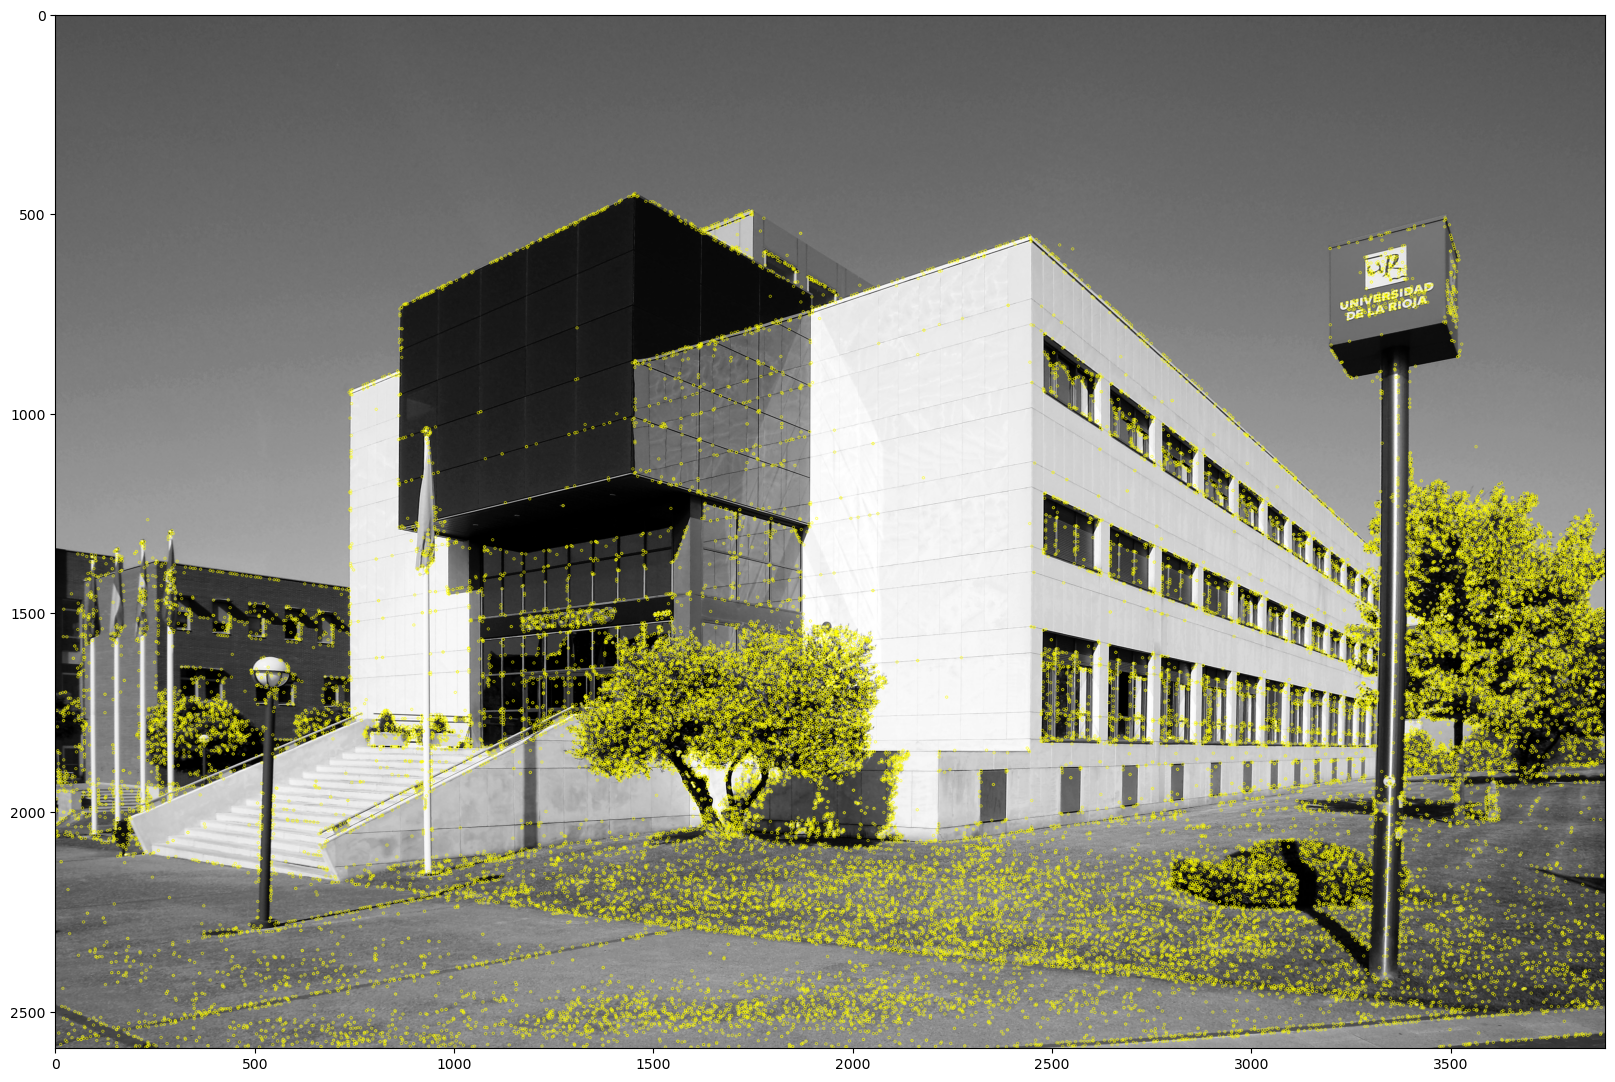

In [ ]:
# Leemos la imagen
img1 = cv2.imread('RectoradoUR.jpg')  
# La pasamos a blanco y negro
gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

#Cargamos SIFT
sift = cv2.SIFT_create()
# Si no te ha funcionado la línea anterior, quizás tengas una versión vieja
# En ese caso, quizás te funcione sift = cv2.xfeatures2d.SIFT_create() 
# Si tampoco te funciona, entonces actualiza OpenCV

# Detectamos los puntos clave
puntos = sift.detect(gray,None) 

#Dibujamos los puntos clave: ¡atentos a los parámetros!
img2=cv2.drawKeypoints(gray,puntos,outImage=None,color=(255,255,0))
#Para que se vea en grande
plt.figure(figsize = (20,20))
plt.imshow(img2)

Vamos a probar con otra imagen.

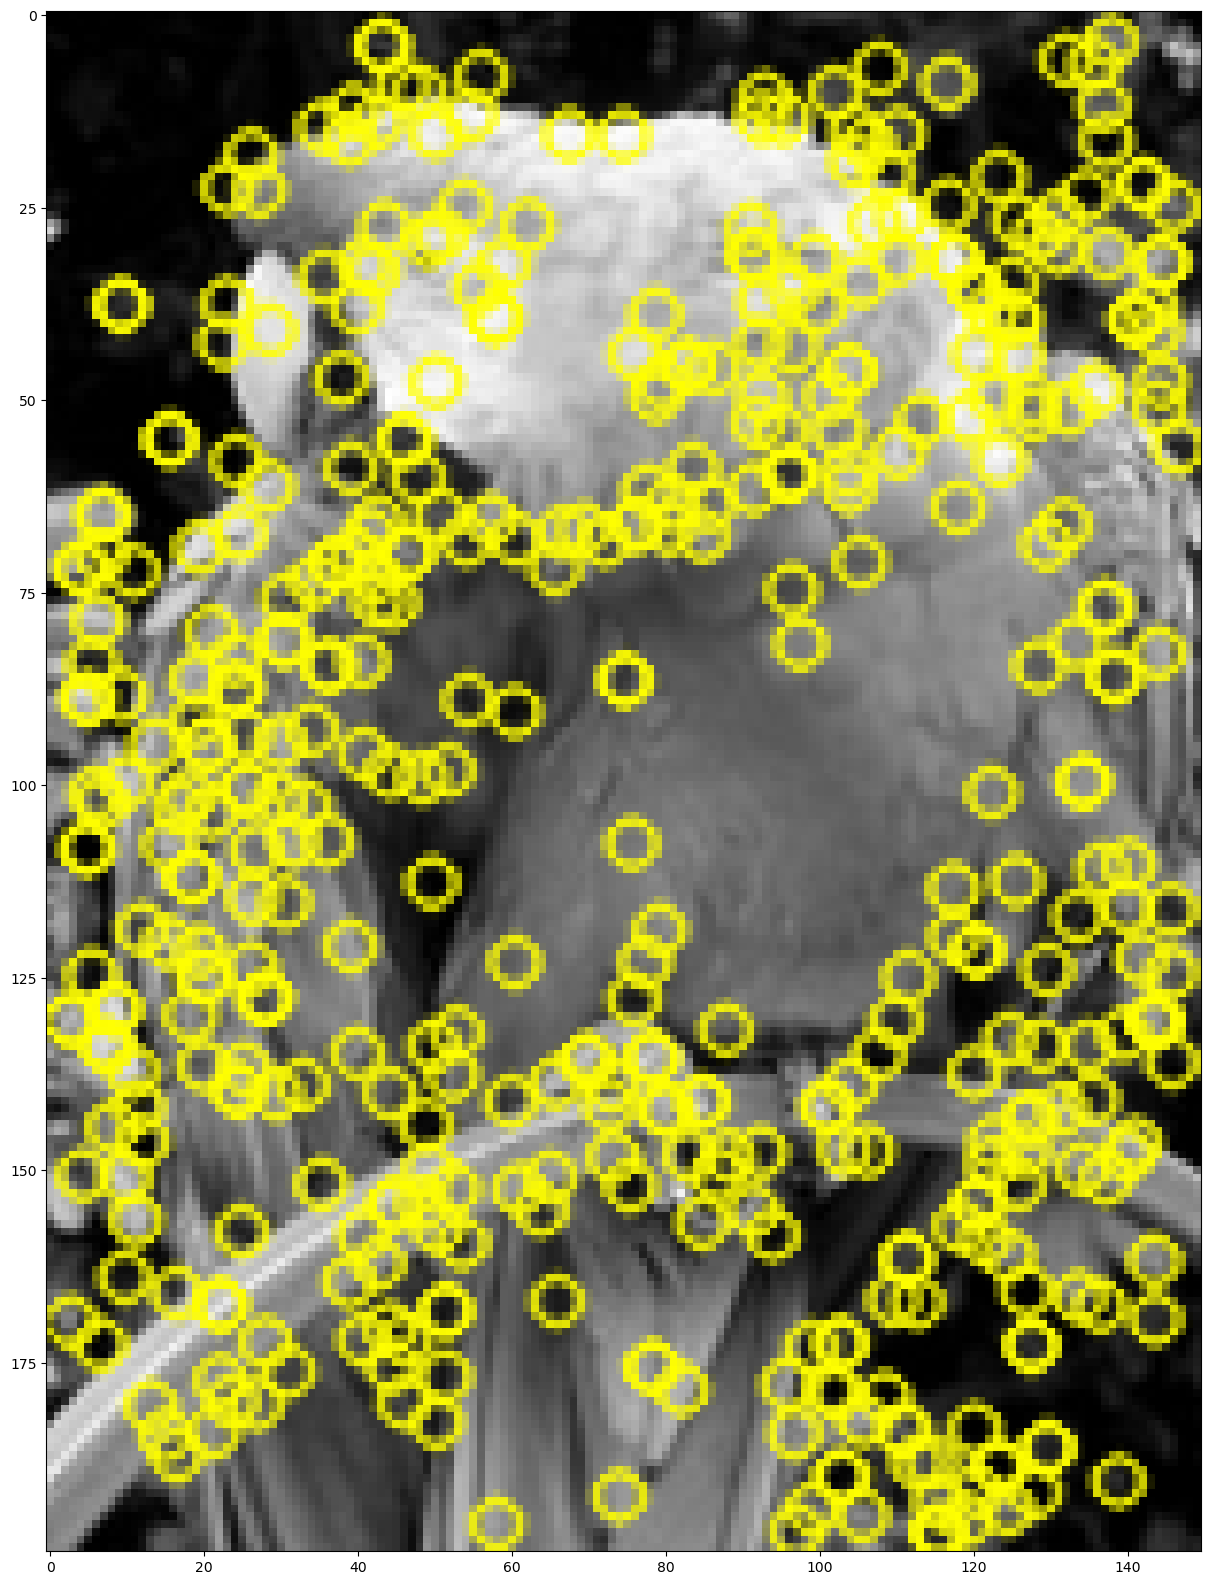

In [ ]:
img1 = cv2.imread('pollo.png')  
# La pasamos a blanco y negro
gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

#Cargamos SIFT
sift = cv2.SIFT_create()
# Si no te ha funcionado la línea anterior, quizás tengas una versión vieja
# En ese caso, quizás te funcione sift = cv2.xfeatures2d.SIFT_create() 
# Si tampoco te funciona, entonces actualiza OpenCV

# Detectamos los puntos clave
puntos = sift.detect(gray,None) 

#Dibujamos los puntos clave: ¡atentos a los parámetros!
img2=cv2.drawKeypoints(gray,puntos,outImage=None,color=(255,255,0))
#Para que se vea en grande
plt.figure(figsize = (20,20))
plt.imshow(img2)

¿Cuántos puntos clave hay?

In [ ]:
len(puntos)

435

En el ejemplo anterior se ha usado <code>sift.detect(gray,None)</code> para detectar los puntos clave. 
SIFT tiene una función que a la vez que detecta, permite calcular los descriptores de los puntos clave 
(un array de dimensión 128 para cada punto, que se corresponde con el histograma de los gradientes).
Es la función <code>sift.detectAndCompute</code>.

- Haz lo mismo que en el ejemplo anterior con una imagen cualquiera que descargues, pero ahora calculando a la vez los descriptores.
- Comprueba que el tamaño de cada uno de los descriptores de un punto es 128
- Muestra el número de puntos clave
- Muestra por pantalla los descriptores de un punto clave

Hacemos el primer ejercicio con otra imagen y calculando los descriptores.

In [ ]:
img1 = cv2.imread('fray_perico.jpg')  
# La pasamos a blanco y negro
gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

#Cargamos SIFT
sift = cv2.SIFT_create()
# Si no te ha funcionado la línea anterior, quizás tengas una versión vieja
# En ese caso, quizás te funcione sift = cv2.xfeatures2d.SIFT_create() 
# Si tampoco te funciona, entonces actualiza OpenCV

# Detectamos los puntos clave y sus descriptores
puntos, descriptores = sift.detectAndCompute(gray,None)
descriptores.shape

(28435, 128)

Vemos que tenemos 28 435 puntos y los 128 descriptores.

Mostramos el número de puntos clave.

In [ ]:
len(puntos)

28435

Como era de esperar los mismas filas que la matriz de descriptores.

Y mostramos por pantalla los descriptores del primer punto clave.

In [ ]:
descriptores[0]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
         0.,   0.,   0.,   0.,   0.,   1.,   5.,   1.,   0.,  10.,   4.,
         0.,   0.,   3.,   1.,   0.,   0.,  26.,  18.,   0.,   0.,   0.,
         0.,  10.,  47.,   8.,   0.,   0.,   0.,  18.,  29.,   6.,  62.,
        86.,   7.,   1.,   2., 104., 113.,   9.,   6.,  56.,  25.,   2.,
        17.,  10.,   5.,   2.,   2., 124., 103.,   1.,   5.,   0.,   0.,
        28., 124.,  15.,   9.,  51.,  26.,  26.,   9.,   8.,  71., 109.,
       121.,  61.,  19., 124., 110.,   9.,  14.,  55.,  33.,   5.,  29.,
        17.,  19.,   6.,  22., 124.,  45.,   1.,   6.,   0.,   0.,  23.,
        60.,   6.,   6.,  58.,  29.,   2.,   3.,  12., 109., 114.,  56.,
        36.,  12., 124.,  63.,   5.,  19.,  57.,  36.,   4.,  21.,  44.,
        12.,   2.,   5., 124.,  62.,   4.,  12.], dtype=float32)

## Ejercicio 2:

Vamos a hacer nuestro clasificador de imágenes. Lo primero es conseguir unas cuantas imágenes. 

### Paso 1: Conseguir imágenes

Vamos a usar un descargador de imágenes, que se conecta a Bing y descarga mediante peticiones HTTP varias imágenes. Se llama <code>bing_image_downloader</code> (https://pypi.org/project/bing-image-downloader/) y lo puedes instalar con <code>pip install bing-image-downloader</code>.

La sintaxis para usarlo es simple y la puedes ver en el enlace anterior. Decide qué dos clases quieres clasificar (por ejemplo, la torre Eiffel VS la estatua de la libertad) y descarga 100 imágenes de cada una de las clases.

<b>NOTA</b>: El descargador de imágenes automático usa Bing. Existen otras utilidades para descargar imágenes usando Google en vez de Bing, por ejemplo:
- Google Images Download (https://pypi.org/project/google_images_download/, instalable con <code>pip install google_images_download</code>)
- Simple Image Download (https://pypi.org/project/simple-image-download/, instalable con <code>pip install simple_image_download</code>) 

Sin embargo, Google es más inestable porque intenta impedir el uso de este tipo de scripts. Puedes probarlas también, pero no garantizo que funcionen (a fecha 21 de mayo de 2023, el de Google me ha fallado).

In [3]:
!pip install bing-image-downloader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from bing_image_downloader import downloader
downloader.download("Luis de Góngora", limit=100,  output_dir='dataset', adult_filter_off=True, force_replace=False, timeout=60)

In [ ]:
downloader.download("Francisco de Quevedo", limit=100,  output_dir='dataset', adult_filter_off=True, force_replace=False, timeout=60, verbose=False)

Separa las imágenes descargadas en carpetas de entrenamiento y test, y dentro de cada una de ellas ten también las imágenes separadas por cada una de las dos clases. Para separar, usa 80%-20%, 75%-25% o 90%-10%, como prefieras. Por ejemplo.

- Entrenamiento
    - Estatua Libertad
    - Torre Eiffel
- Test
    - Estatua Libertad
    - Torre Eiffel
        

Separamos las imágenes entre entrenamiento y test. Sé que hay una función para hacerlo, pero lo he hecho a mano (se podría usar split-folders). Realmente sé que saldrá regular porque tengo pocos datos y muy pocas imágenes. 

### Paso 2: Crear el array de características

Recorre todos las imágenes de la carpeta de entrenamiento, pásalas a blanco y negro, calcula los puntos clave SIFT y los descriptores de cada punto clave, y guarda dichos descriptores en una matriz de N filas (siendo N el número de puntos clave SIFT) y 128 columnas.

Para recorrer carpetas y subcarpetas, te puede resultar útil el siguiente esquema:

<code>directorio = r'C:\Users\LA RUTA...'  
files = [os.path.join(path, name) for path, subdirs, files in os.walk(directorio) for name in files]
for file in files:
</code>


In [ ]:
directorio = r'dataset\Entrenamiento'
descriptores_vec = []
n_desc = []
files = [os.path.join(path, name) for path, subdirs, files in os.walk(directorio) for name in files]
for i, file in enumerate(files):
    print(f"Fase {i} de {len(files)}", end="\r")
    img1 = cv2.imread(file, cv2.IMREAD_UNCHANGED)
    # La pasamos a blanco y negro
    gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

    #Cargamos SIFT
    sift = cv2.SIFT_create()

    # Detectamos los puntos clave y sus descriptores
    _, descriptores = sift.detectAndCompute(gray,None)
    descriptores_vec.append(descriptores)
    n_desc.append(descriptores.shape[0])

In [ ]:
import numpy

descriptores_vec = numpy.concatenate(descriptores_vec, axis=0)
descriptores_vec

array([[38., 69., 17., ..., 24.,  7.,  5.],
       [ 0.,  0.,  0., ..., 19.,  2.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  5.],
       ...,
       [ 8.,  2.,  0., ...,  0.,  0.,  0.],
       [ 0., 10., 52., ...,  0.,  0.,  0.],
       [ 0.,  8., 30., ...,  0.,  0.,  1.]], dtype=float32)

In [ ]:
descriptores_vec.shape

(183592, 128)

### Paso 3: Kmeans para hacer la bolsa de palabras

Usa KMeans (o mejor, MiniBatchKMeans) para hacer la "bolsa de palabras". 

OJO: lo recomendable es poner entre 500 y 1000 clusters, pero de momento pon solo 100 para que no te tarde demasiado en calcularlo.

In [ ]:
import pandas as pd

df = pd.DataFrame(descriptores_vec)
df = df.astype(float)
df.head()

In [ ]:
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=100,
                          random_state=0,
                          batch_size=6)
res_kmeans = kmeans.fit_predict(df)

In [ ]:
res_kmeans

array([66, 93, 23, ..., 43,  7,  7])

### Paso 4: Hacemos los histogramas de las palabras que tiene cada imagen

Creamos una matriz con número de filas igual al número de imagenes, y de columnas el número de clusters.

Para cada imagen, decidimos a qué palabra (qué cluster) pertenece cada descriptor y vamos contando. 
IMPORTANTE: normalizamos el historial de cada imagen antes de añadirlo a la matriz de historiales!! Por ejemplo, con <code>cv2.normalize(hist_imagen_i, hist_imagen_i, norm_type=cv2.NORM_L1)</code>

Creamos también el vector de "targets", que nos dice a qué clase pertenece cada imagen (esa información la tenemos gracias a que las tenemos separadas en carpetas)

In [ ]:
from sklearn.preprocessing import normalize

directorio = r'dataset/Entrenamiento'
contador = 0
files = [os.path.join(path, name) for path, subdirs, files in os.walk(directorio) for name in files]
zero_data = np.zeros(shape=(len(files),100))
df_def = pd.DataFrame(zero_data)
df_def["Etiqueta"] = " "
for i, file in enumerate(files):
    cachos = file.split('\\')
    clase = cachos[-2]
    #print(f"Fase {i} de {len(files)}", end="\r")
    
    x = res_kmeans[contador:contador+n_desc[i]]
    y = np.bincount(x)
    ii = np.nonzero(y)[0]
    aux = [list(a) for a in zip(ii,y[ii])]
    aux = pd.DataFrame(aux)

    aux.iloc[:,1] = normalize([aux.iloc[:,1].values])[0]
    aux = aux.values.tolist()
    
    contador += n_desc[i]
    for elem in aux:
        df_def.iloc[i,int(elem[0])] = elem[1]
    df_def.iloc[i,100] = clase

In [ ]:
df_def.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,Etiqueta
0,0.060415,0.130900,0.060415,0.100692,0.130900,0.040277,0.120831,0.050346,0.080554,0.140969,...,0.090623,0.060415,0.030208,0.171177,0.050346,0.171177,0.0,0.0,0.000000,Francisco de Quevedo
1,0.048212,0.160706,0.128565,0.000000,0.096424,0.016071,0.032141,0.096424,0.160706,0.144635,...,0.128565,0.032141,0.048212,0.112494,0.112494,0.064282,0.0,0.0,0.000000,Francisco de Quevedo
2,0.065822,0.032911,0.115188,0.000000,0.065822,0.000000,0.082277,0.065822,0.164555,0.164555,...,0.016455,0.000000,0.049366,0.098733,0.032911,0.098733,0.0,0.0,0.016455,Francisco de Quevedo
3,0.032406,0.000000,0.113421,0.032406,0.178233,0.016203,0.194436,0.016203,0.064812,0.081015,...,0.097218,0.016203,0.162030,0.097218,0.016203,0.097218,0.0,0.0,0.032406,Francisco de Quevedo
4,0.028967,0.043451,0.057935,0.028967,0.144836,0.028967,0.202771,0.028967,0.057935,0.043451,...,0.130353,0.043451,0.275189,0.086902,0.014484,0.115869,0.0,0.0,0.028967,Francisco de Quevedo


### Paso 5: 

Creamos el clasificador (<code>clasificador = svm.SVC(probability=True)</code>) y lo entrenamos.


Es necesario transformar las etiquetas a label encoder.

In [ ]:
df_def["Etiqueta"]

0      Francisco de Quevedo
1      Francisco de Quevedo
2      Francisco de Quevedo
3      Francisco de Quevedo
4      Francisco de Quevedo
               ...         
121         Luis de Gongora
122         Luis de Gongora
123         Luis de Gongora
124         Luis de Gongora
125         Luis de Gongora
Name: Etiqueta, Length: 126, dtype: object

In [ ]:
y = df_def["Etiqueta"]
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
y

In [ ]:
from sklearn.svm import SVC
X = df_def.iloc[:,:-1]
clasificador = svm.SVC(probability=True)
clasificador.fit(X, y)

## Predecir

Ahora ya podemos predecir. Coge una imagen cualquiera de las de test, pásala a blanco y negro, calcula sus puntos claves con SIFT y los descriptores, mira a qué cluster pertenece cada descriptor y crea el histograma de palabras. Con ese histograma de palabras y el clasificador, 
muestra por pantalla la predicción de a qué clase pertenece.

In [ ]:
imagen = cv2.imread("dataset/Test/Francisco de Quevedo/Image_9.jpg", cv2.IMREAD_UNCHANGED)
gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

#Cargamos SIFT
sift = cv2.SIFT_create()

# Detectamos los puntos clave y sus descriptores
_, desc = sift.detectAndCompute(gray,None)

In [ ]:
desc = np.array(desc, dtype=np.double)

In [ ]:
zero_data = np.zeros(shape=(1,100))
df_test = pd.DataFrame(zero_data)
preds = kmeans.predict(desc)
y = np.bincount(preds)
ii = np.nonzero(y)[0]
aux = [list(a) for a in zip(ii,y[ii])]
aux = pd.DataFrame(aux)

aux.iloc[:,1] = normalize([aux.iloc[:,1].values])[0]
aux = aux.values.tolist()
for elem in aux:
    df_test.iloc[0,int(elem[0])] = elem[1]

In [ ]:
df_test

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.159452,0.239178,0.084155,0.01624,0.082679,0.008858,0.079726,0.075297,0.047245,0.219984,...,0.219984,0.062009,0.048721,0.032481,0.088584,0.041339,0.044292,0.0,0.0,0.001476


In [ ]:
clasificador.predict(df_test)

array([0])

In [ ]:
le.inverse_transform(clasificador.predict(df_test))

array(['Francisco de Quevedo'], dtype=object)

Esta la ha acertado, pero como tenemos pocas imágenes y son todas muy parecidas no es demasiado extraño.

In [ ]:
directorio = r'dataset/Test'
contador = 0
files = [os.path.join(path, name) for path, subdirs, files in os.walk(directorio) for name in files]
zero_data = np.zeros(shape=(len(files),100))
df_test = pd.DataFrame(zero_data)
y_true = []
for i, file in enumerate(files):
    cachos = file.split('\\')
    clase = cachos[-2]
    imagen = cv2.imread(file, cv2.IMREAD_UNCHANGED)
    gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

    #Cargamos SIFT
    sift = cv2.SIFT_create()

    # Detectamos los puntos clave y sus descriptores
    _, desc = sift.detectAndCompute(gray,None)
    #print(f"Fase {i} de {len(files)}", end="\r")
    
    x = kmeans.predict(np.array(desc, dtype=np.double))
    y = np.bincount(x)
    ii = np.nonzero(y)[0]
    aux = [list(a) for a in zip(ii,y[ii])]
    aux = pd.DataFrame(aux)

    aux.iloc[:,1] = normalize([aux.iloc[:,1].values])[0]
    aux = aux.values.tolist()
    
    contador += n_desc[i]
    for elem in aux:
        df_test.iloc[i,int(elem[0])] = elem[1]
    y_true.append(clase)

In [ ]:
df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.053124,0.098076,0.106249,0.063341,0.075600,0.030649,0.369828,0.051081,0.040865,0.091946,...,0.126681,0.091946,0.057211,0.310574,0.059254,0.057211,0.069470,0.000000,0.000000,0.012259
1,0.033123,0.059499,0.138013,0.027603,0.060113,0.047231,0.271120,0.071767,0.104277,0.041097,...,0.072994,0.121452,0.039871,0.076061,0.049685,0.049071,0.128199,0.001840,0.012268,0.005521
2,0.040562,0.027869,0.020051,0.047921,0.032284,0.144957,0.318060,0.005427,0.040746,0.020695,...,0.015084,0.026950,0.203364,0.010669,0.020051,0.003311,0.078089,0.029249,0.042770,0.079561
3,0.159452,0.239178,0.084155,0.016240,0.082679,0.008858,0.079726,0.075297,0.047245,0.219984,...,0.219984,0.062009,0.048721,0.032481,0.088584,0.041339,0.044292,0.000000,0.000000,0.001476
4,0.157859,0.131960,0.104828,0.016033,0.018499,0.118394,0.075230,0.028365,0.076463,0.051798,...,0.061664,0.054264,0.011099,0.088796,0.061664,0.041931,0.043165,0.001233,0.006166,0.002467


In [ ]:
y_true

['Francisco de Quevedo',
 'Francisco de Quevedo',
 'Francisco de Quevedo',
 'Francisco de Quevedo',
 'Luis de Gongora',
 'Luis de Gongora',
 'Luis de Gongora',
 'Luis de Gongora']

In [ ]:
le.inverse_transform(clasificador.predict(df_test))

array(['Francisco de Quevedo', 'Francisco de Quevedo', 'Luis de Gongora',
       'Francisco de Quevedo', 'Luis de Gongora', 'Luis de Gongora',
       'Francisco de Quevedo', 'Luis de Gongora'], dtype=object)

In [ ]:
y_pred = le.inverse_transform(clasificador.predict(df_test))

In [ ]:
score = 0
for i, elem in enumerate(y_pred):
    if elem == y_true[i]:
        score+=1
score/len(y_true)

0.75

De nuevo, no tenemos muchos datos y es complicado añadir nuevos, así que un 75% no está nada mal.

Finalmente, crea una función que te diga la precisión que tiene el clasificador, evaluando todas las imágenes de las carpetas de test. Mejora la precisión, por ejemplo:
- Aumentando el número de clusters
- Aumentando el número de imágenes
- Probando con otros clasificadores
- etc.

Vamos a intentar mejorar los resultados, pero no podemos aumentar el número de imágenes.

Comenzamos aumentando el número de clústers a 500.

In [ ]:
kmeans = MiniBatchKMeans(n_clusters=500,
                          random_state=0,
                          batch_size=6)
res_kmeans = kmeans.fit_predict(df)
directorio = r'dataset/Entrenamiento'
contador = 0
files = [os.path.join(path, name) for path, subdirs, files in os.walk(directorio) for name in files]
zero_data = np.zeros(shape=(len(files),500))
df_def = pd.DataFrame(zero_data)
df_def["Etiqueta"] = " "
for i, file in enumerate(files):
    cachos = file.split('\\')
    clase = cachos[-2]
    #print(f"Fase {i} de {len(files)}", end="\r")
    
    x = res_kmeans[contador:contador+n_desc[i]]
    y = np.bincount(x)
    ii = np.nonzero(y)[0]
    aux = [list(a) for a in zip(ii,y[ii])]
    aux = pd.DataFrame(aux)

    aux.iloc[:,1] = normalize([aux.iloc[:,1].values])[0]
    aux = aux.values.tolist()
    
    contador += n_desc[i]
    for elem in aux:
        df_def.iloc[i,int(elem[0])] = elem[1]
    df_def.iloc[i,500] = clase

C:\Users\Pablo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 5120 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


In [ ]:
y = df_def["Etiqueta"]
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
X = df_def.iloc[:,:-1]
clasificador = svm.SVC(probability=True)
clasificador.fit(X, y)

SVC(probability=True)

In [ ]:
directorio = r'dataset/Test'
contador = 0
files = [os.path.join(path, name) for path, subdirs, files in os.walk(directorio) for name in files]
zero_data = np.zeros(shape=(len(files),500))
df_test = pd.DataFrame(zero_data)
y_true = []
for i, file in enumerate(files):
    cachos = file.split('\\')
    clase = cachos[-2]
    imagen = cv2.imread(file, cv2.IMREAD_UNCHANGED)
    gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

    #Cargamos SIFT
    sift = cv2.SIFT_create()

    # Detectamos los puntos clave y sus descriptores
    _, desc = sift.detectAndCompute(gray,None)
    #print(f"Fase {i} de {len(files)}", end="\r")
    
    x = kmeans.predict(np.array(desc, dtype=np.double))
    y = np.bincount(x)
    ii = np.nonzero(y)[0]
    aux = [list(a) for a in zip(ii,y[ii])]
    aux = pd.DataFrame(aux)

    aux.iloc[:,1] = normalize([aux.iloc[:,1].values])[0]
    aux = aux.values.tolist()
    
    contador += n_desc[i]
    for elem in aux:
        df_test.iloc[i,int(elem[0])] = elem[1]
    y_true.append(clase)

In [ ]:
score = 0
y_pred = le.inverse_transform(clasificador.predict(df_test))
for i, elem in enumerate(y_pred):
    if elem == y_true[i]:
        score+=1
score/len(y_true)

0.75

No mejoramos aumentando el número de clústers. Podemos porbar con otro clasificador.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

y = df_def["Etiqueta"]
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
clasificador = RandomForestClassifier()
clasificador.fit(X, y)

RandomForestClassifier()

In [ ]:
score = 0
y_pred = le.inverse_transform(clasificador.predict(df_test))
for i, elem in enumerate(y_pred):
    if elem == y_true[i]:
        score+=1
score/len(y_true)

0.625

Con este otro clasificador empeora.<br><br> Y con esto, hemos terminado la parte obligatoria. Vemos que los resultados no son excesivamente malos, pero con más imágenes y escogiendo clases que sí tengan un sentido y sean algo populares para poder encontrar buenas imágenes se pueden obtener resultados interesantes.

## Ejercicio 3 (opcional):

Adapta todo el código anterior para que pueda funcionar con más de dos clases, automatizando además totalmente el proceso: 
1) La descarga de imágenes
2) Separación en carpetas
3) Entrenamiento automático haciendo validación cruzada en la carpeta de train, con distintos algoritmos de clasificación, mostrando las métricas.
4) Automáticamente te devuelva el mejor de los algoritmos y que puedas hacer predicciones de carpetas enteras con él, mostrando la métrica (precisión).

Es decir, bien créate una clase cuyo constructor simplemente reciba lo que quieras clasificar:
<code>
    A = MiClasificador("peras", "manzanas") # Esto se descargará las imágenes, separará en carpetas...
    A.fit() # O le puedes meter parámetros si quieres (el número de clusteres, los clasificadores a usar, ...)
    A.predict("ruta a una carpeta") # A predecir!
</code>

O alternativamente, simplemente una función: <code>def miClasificador(*args)</code> que devuelva el modelo entrenado y otra función <code>def clasificar(modelo, carpeta)</code> que haga la clasificación.

O cualquier otra alternativa similar que se te ocurra.

Pues vamos a ello, había pensado hacer un método enorme que recibiera muchos parámetros y se encargara de todo; pero creo que lo mejor es, como sugiere el enunciado, hacer una clase con diferentes métodos. He puesto los nombres en francés porque me ha apetecido muchísimo.

In [1]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install bing-image-downloader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import cv2
from bing_image_downloader import downloader
import os
import splitfolders
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from sklearn import preprocessing
import numpy as np

class LeTrieur:

  def __init__(self, classe1, classe2, dossier = "dataset", limite = 100):
    
    # Nous créons le dossier et le remplissons d'images
    os.makedirs(dossier, exist_ok=True) 
    downloader.download(classe1, limit=100,  output_dir=dossier, verbose=False,
                        adult_filter_off=True, force_replace=False, timeout=60)
    downloader.download(classe2, limit=100,  output_dir=dossier, verbose=False,
                        adult_filter_off=True, force_replace=False, timeout=60)
    
    # Maintenant, nous séparons les ensembles de formation et de test
    splitfolders.ratio(dossier, output=dossier, seed=0, ratio=(.8, 0.2,))

    # Et nous générons les descripteurs
    répertoire = dossier+'/train'
    descripteurs_vec = []
    n_desc = []
    files = [os.path.join(path, name) for path, subdirs, files in os.walk(répertoire) for name in files]
    for i, file in enumerate(files):
        try:
            print(f"Phase {i} sur {len(files)}", end="\r")
            img1 = cv2.imread(file, cv2.IMREAD_UNCHANGED)
            # La pasamos a blanco y negro
            gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

            #Cargamos SIFT
            sift = cv2.SIFT_create()

            # Detectamos los puntos clave y sus descriptores
            _, descripteurs = sift.detectAndCompute(gray,None)
            descripteurs_vec.append(descripteurs)
            n_desc.append(descripteurs.shape[0])
        except:
            # Nous ne faisons rien, car le fichier aura une extension erronée.
            pass
    self.descripteurs = np.concatenate(descripteurs_vec, axis=0)
    self.dossier = dossier
    self.n_desc = n_desc
  
  def Adapter(self, n_grappes, modèle):

    self.modèle = modèle
    self.n_grappes = n_grappes

    df = pd.DataFrame(self.descripteurs)
    df = df.astype(float)

    # Nous calculons les groupes
    kmeans = MiniBatchKMeans(n_clusters=100,
                              random_state=0,
                              batch_size=6)
    self.kmeans = kmeans
    
    res_kmeans = self.kmeans.fit_predict(df)

    # Les histogrammes
    répertoire = self.dossier+'/train'
    compteur = 0
    files = [os.path.join(path, name) for path, subdirs, files in os.walk(répertoire) for name in files]
    zero_data = np.zeros(shape=(len(files),self.n_grappes))
    df_def = pd.DataFrame(zero_data)
    df_def["Étiquette"] = " "
    for i, file in enumerate(files):
        morceaux = file.split('/')
        classe = morceaux[-2]
        
        x = res_kmeans[compteur:compteur+self.n_desc[i]]
        y = np.bincount(x)
        ii = np.nonzero(y)[0]
        aux = [list(a) for a in zip(ii,y[ii])]
        aux = pd.DataFrame(aux)

        aux.iloc[:,1] = preprocessing.normalize([aux.iloc[:,1].values])[0]
        aux = aux.values.tolist()
        
        compteur += self.n_desc[i]
        for elem in aux:
            df_def.iloc[i,int(elem[0])] = elem[1]
        df_def.iloc[i,100] = classe

    # Nous entraînons le modèle
    y = df_def["Étiquette"]
    le = preprocessing.LabelEncoder()
    self.le = le
    y = self.le.fit_transform(y)
    X = df_def.iloc[:,:-1]

    self.modèle.fit(X, y)

  def Prévoir(self, itinéraire = None):
      if not itinéraire:
        répertoire = self.dossier+'/val'
      else:
        répertoire = itinéraire
      compteur = 0
      files = [os.path.join(path, name) for path, subdirs, files in os.walk(répertoire) for name in files]
      zero_data = np.zeros(shape=(len(files),self.n_grappes))
      df_test = pd.DataFrame(zero_data)
      y_true = []
      for i, file in enumerate(files):
          try:
              morceaux = file.split('/')
              classe = morceaux[-2]
              image = cv2.imread(file, cv2.IMREAD_UNCHANGED)
              gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

              #Cargamos SIFT
              sift = cv2.SIFT_create()

              # Detectamos los puntos clave y sus descriptores
              _, desc = sift.detectAndCompute(gray,None)
              #print(f"Fase {i} de {len(files)}", end="\r")
              
              x = self.kmeans.predict(np.array(desc, dtype=np.double))
              y = np.bincount(x)
              ii = np.nonzero(y)[0]
              aux = [list(a) for a in zip(ii,y[ii])]
              aux = pd.DataFrame(aux)

              aux.iloc[:,1] = preprocessing.normalize([aux.iloc[:,1].values])[0]
              aux = aux.values.tolist()
              for elem in aux:
                  df_test.iloc[i,int(elem[0])] = elem[1]
              y_true.append(classe)
          except:
            pass
      self.résultat = self.le.inverse_transform(self.modèle.predict(df_test))
      self.réel = y_true
      self.AfficherRésultat()

  def AfficherRésultat(self):
    score = 0
    for i, elem in enumerate(self.réel):
        if elem == self.résultat[i]:
            score+=1
    print("Score: "+str(score/len(self.réel)))

In [4]:
from sklearn.ensemble import RandomForestClassifier

A = LeTrieur("Peras", "Manzanas")
clf = RandomForestClassifier()
A.Adapter(100, clf)
A.Prévoir()

[%] Downloading Images to /content/dataset/Peras
[Error]Invalid image, not saving http://www.grupopm.com/hechoencalifornia/multimedia/descargas/fotos/peras/pera4.jpg

[!] Issue getting: http://www.grupopm.com/hechoencalifornia/multimedia/descargas/fotos/peras/pera4.jpg
[!] Error:: Invalid image, not saving http://www.grupopm.com/hechoencalifornia/multimedia/descargas/fotos/peras/pera4.jpg

[Error]Invalid image, not saving http://www.fotoswiki.net/Uploads/fotoswiki.net/ImagenesGrandes/peras-1.jpg

[!] Issue getting: http://www.fotoswiki.net/Uploads/fotoswiki.net/ImagenesGrandes/peras-1.jpg
[!] Error:: Invalid image, not saving http://www.fotoswiki.net/Uploads/fotoswiki.net/ImagenesGrandes/peras-1.jpg

[!] Issue getting: http://blog.cocinaycomparte.com/wp-content/uploads/2016/10/Ripe-green-pears-isolated-with-leaves-isolated-000086449883_Medium.jpg
[!] Error:: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>
[!] Issue getti

Copying files: 200 files [00:00, 2525.99 files/s]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Score: 0.875


Ale, pues práctica terminada.